# 1. Starting point

Input: (256, 256, 3) Chest X-ray image 566개
<br>
Label: 좌우 lung 마스킹되어 있는 흑백 이미지 566개
<br><br>
이미지 기준 좌측 폐: Right lung
이미지 기준 우측 폐: Left lung
<br>
※ Task<br>
&nbsp;&nbsp;&nbsp;    - Left lung, Right lung 분할(2 classes + 1 class(background)) <br>
&nbsp;&nbsp;&nbsp;    - 훈련 & 추론 + 후처리(보간법) 노이즈 제거(예측 성능 ↑)

## 데이터 구조

data <br>
&nbsp;&nbsp;    └ image/ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        resize_CHNCXR_0001_0.png <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        resize_CHNCXR_0002_0.png <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        resize_CHNCXR_0003_0.png <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        ... <br>
&nbsp;&nbsp;    └ label/                     -> 사전 작업 후에는 사용하지 않습니다. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        resize_CHNCXR_0001_0.png <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        resize_CHNCXR_0002_0.png <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        resize_CHNCXR_0003_0.png <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        ...    
&nbsp;&nbsp;    └ label_rl/ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;               └ r/ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;                    resize_CHNCXR_0001_0.png <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;                    resize_CHNCXR_0002_0.png <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;                    resize_CHNCXR_0003_0.png <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;                    ... <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;               └ l/ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;                    resize_CHNCXR_0001_0.png <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;                    resize_CHNCXR_0002_0.png <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;                    resize_CHNCXR_0003_0.png <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;                    ...

## 사전 작업

label 폴더의 마스킹 이미지를 각각 좌측 폐('label_rl/l/*'), 우측 폐'label_rl/r/*'로 분할하여 어노테이션 처리하였습니다.<br>
추후 작업 시 라벨링을 배경: 0, 좌측 폐: 1, 우측 폐: 2로 하고 다시 one-hot encoding 작업으로 분할하여 진행한다.

# 2. Library Import

In [1]:
import os
import time
import datetime
import pickle
import statistics
from tqdm import tqdm
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Add, Input, Dense, Conv2D, Flatten, MaxPool2D, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 3. Data Preprocessing

## 3-1. 사용 데이터 살펴보기

Input image


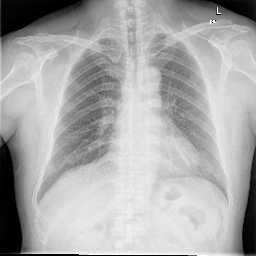

Right lung mask


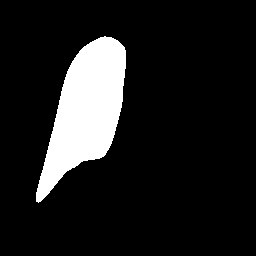

Left lung mask


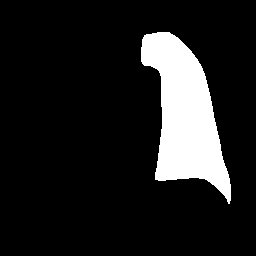

In [2]:
from IPython.display import Image, display

print("Input image")
display(Image('./data/image/resize_CHNCXR_0001_0.png'))
print("Right lung mask")
display(Image('./data/label_rl/r/resize_CHNCXR_0001_0.png'))
print("Left lung mask")
display(Image('./data/label_rl/l/resize_CHNCXR_0001_0.png'))

## 3-2. 픽셀 히스토그램 살펴보기

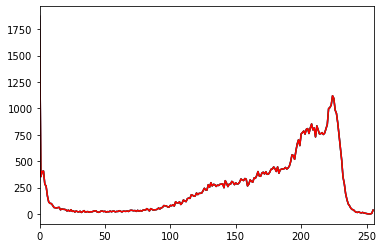

In [3]:
# image sample 1장
image_sample = cv2.imread('./data/image/resize_CHNCXR_0001_0.png')
color = ('b', 'g', 'r')
for i, col in enumerate(color):
    histr = cv2.calcHist([image_sample], [i], None, [256], [0, 256])
    plt.plot(histr, color = col)
    plt.xlim([0, 256])
plt.show()

(256, 256, 3)


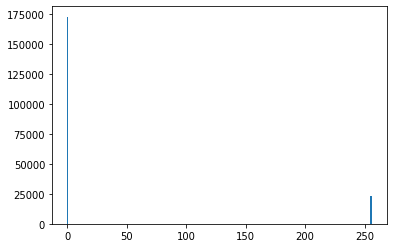

In [4]:
# mask sample 1장
mask_sample = cv2.imread('./data/label_rl/r/resize_CHNCXR_0001_0.png')#, cv2.IMREAD_GRAYSCALE)
print(mask_sample.shape)

plt.hist(mask_sample.ravel(), 256, [0, 256])
plt.show()

## 3-3. 데이터 처리

### 3-3-1. Seed Fix

In [5]:
# fix random seed for reproductibility
seed = 777
np.random.seed(seed)
tf.random.set_seed(seed)

### 3-3-2. Hyper parameters

In [6]:
# hyper parameter
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
N_CLASSES = 3
EPOCHS = 80
BATCH_SIZE = 32

### 3-3-3. Label Masking

In [7]:
data_path = './data/'

files = os.listdir(os.path.join(data_path, 'image'))
file_headers = [] # 현재 디렉터리 파일 리스트
for f in files:
    f1 = os.path.splitext(f)[0] # splitext (이미지 이름, 확장자)
    file_headers.append(f1)

    
X_all = np.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8) # Input image
y_all = np.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, N_CLASSES), dtype=np.bool) # label

count = 0
for fh in tqdm(file_headers):
    f1 = os.path.join(data_path, 'image', '{}.png'.format(fh))           # image list
    label_r = os.path.join(data_path, 'label_rl/r', '{}.png'.format(fh)) # r label image list
    label_l = os.path.join(data_path, 'label_rl/l', '{}.png'.format(fh)) # l label image list
    
    img = imread(f1)[:, :, :IMG_CHANNELS]
#     print(img.shape) # (256, 256, 3)

    """
    ■ label
        ● background: 0
        ● Left lung:  1 
        ● Right lung: 2
    
    아래 코드에서의 레이블 영역 생성 흐름
    : 1. mask_r 이미지의 (우측 폐) 영역 1, 배경 영역 0
      2. mask_l 이미지의 (좌측 폐) 영역 1, 배경 영역 0
      3. mask 변수에 mask_r과 mask_l을 덧셈 연산(cv2.add)한다.
      4. mask 변수에 mask_r을 덧셈 연산한다.
      5. 3번의 과정에서 생긴 이미지는 좌우측 폐가 1을 가지고 배경은 0을 가진다.
         4번의 과정을 거치면서 우측 폐 영역의 덧셈 연산이 일어나고 우측 폐가 2를 가진다.
      6. 배경 0, 좌측 폐 1, 우측 폐 2를 가진 이미지(256, 256, 1)를 원핫 인코딩을 하고 저장한다.
    """
    
    mask_r = imread(label_r, as_gray=True) # (256, 256)    
    mask_r[mask_r == 1] = 1
    mask_r[mask_r != 1] = 0
    
    mask_l = imread(label_l, as_gray=True) # (256, 256)
    mask_l[mask_l == 1] = 1
    mask_l[mask_l != 1] = 0
    
    mask = cv2.add(mask_r, mask_l)
    mask = cv2.add(mask, mask_r) # (256, 256)

    mask = np.expand_dims(mask, axis = -1) # 차원 증가
    mask = tf.keras.utils.to_categorical(y = mask, num_classes = N_CLASSES) # 원핫 인코딩
    
    X_all[count] = img
    y_all[count] = mask

    count += 1

100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:08<00:00, 63.62it/s]


In [8]:
print(X_all.shape)
print(y_all.shape)

(566, 256, 256, 3)
(566, 256, 256, 3)


**데이터 정규화 & 슬라이싱 처리**

In [9]:
X_all = X_all.astype('float32') / 255. # 픽셀 정규화
y_all = y_all.astype('float32')

In [10]:
# data slicing
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [11]:
print('X_train', X_train.shape)
print('X_valid', X_valid.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_valid', y_valid.shape)
print('y_test', y_test.shape)

X_train (361, 256, 256, 3)
X_valid (91, 256, 256, 3)
X_test (114, 256, 256, 3)
y_train (361, 256, 256, 3)
y_valid (91, 256, 256, 3)
y_test (114, 256, 256, 3)


**슬라이싱된 데이터 확인**

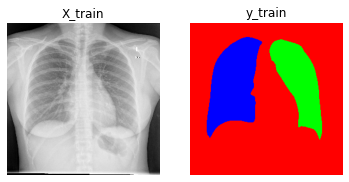

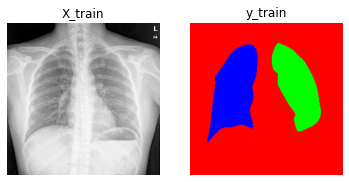

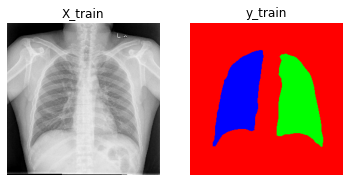

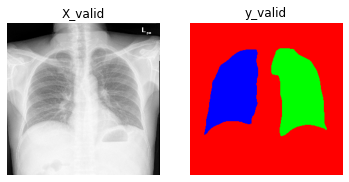

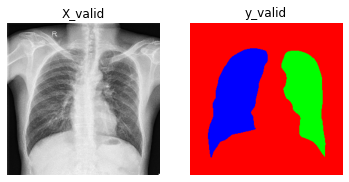

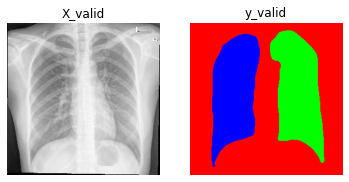

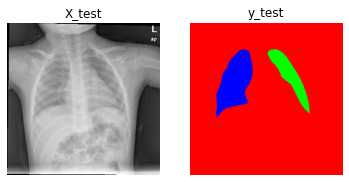

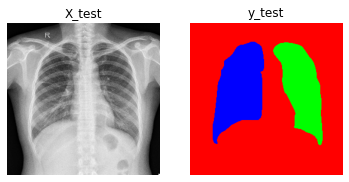

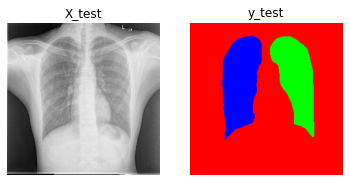

In [12]:
def plotTrainData(a,b,c):
    for i in range(3):
        ix = np.random.randint(0, len(a))
        plt.subplot(1,2,1)
        plt.title("X_" + c)
        plt.imshow(a[ix])
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.title("y_" + c)
        plt.imshow(np.squeeze(b[ix]))#, 'gray')
        plt.axis('off')
        plt.show()
        
plotTrainData(X_train,y_train, 'train')
plotTrainData(X_valid,y_valid, 'valid')
plotTrainData(X_test,y_test, 'test')

# 4. Modeling(U-Net)

![대체 텍스트](https://www.renom.jp/notebooks/tutorial/image_processing/u-net/unet.png)

## 4-1. Model

In [13]:
# U-Net model
# 신경망의 끝단을 MLP가 아닌 CNN을 채택함으로서 기존의 MLP에서의 Flatten으로
# 인한 이미지 특성의 보존이 약해지는 것을 보완하고자 하였다.
# Input: (H, W, C)
# Output: FCN을 사용하여,
#         합성곱(분류 클래스 개수, kernel_size, activation)
# 이미지 해상도를 Maxpooling(<-> Upsampling)하여 줄여나가다(채널은 증가)
# Upsampling으로 작아진 해상도를 늘리며 주변 픽셀을 예측해 값을 채운다.
# 가장 특징적인 점은 Skip connection 기법으로 은닉층을 거칠수록 피쳐맵이 형이상학적인 모양을 띄어가는데
# 그 이전에 초반 레이어 단에서의 비교적 단순한 피쳐맵(수평선, 수직선, 곡선같은 모양)을 Concatenate하여
# 후반 레이어 단에 연결시켜 가중치를 더하는 역할을 한다.
def unet(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPool2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up6 = Concatenate()([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = Concatenate()([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up8 = Concatenate()([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = Concatenate()([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(N_CLASSES, (1, 1), activation='softmax')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

## 4-2. Compile & Fit

In [14]:
# Loss function 계산
# dice coefficient영역이 얼마나 겹치는지를(교집합) 판단하여 오차를 계산한다.(=F1 score)
def dice_coef(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + 1) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

### If model Fited and saved.. execute

In [15]:
model = load_model('./model/20211129-151140.h5', custom_objects={'dice_coef':dice_coef, 'dice_coef_loss':dice_coef_loss})

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=dice_coef_loss,
              optimizer=sgd,
              metrics=[dice_coef])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        batch_normalization[0][0]        
______________________________________________________________________________________________

In [57]:
from tensorflow.keras.preprocessing import image as kimage

sample_img_path = './data/image/resize_CHNCXR_0001_0.png'
sample_img = kimage.load_img(sample_img_path)
img_tensor = kimage.img_to_array(sample_img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)
print(img_tensor[0].shape)

(1, 256, 256, 3)
(256, 256, 3)


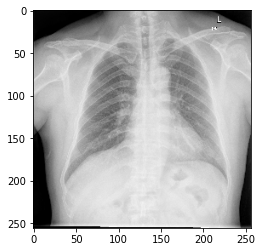

In [55]:
plt.imshow(img_tensor[0])
plt.show()

In [60]:
type(model.layers)

list

In [78]:
layer_names = []
for layer in model.layers:
    # print(type(layer)) # <class 'tensorflow.python.keras.engine.input_layer.InputLayer'>
    # print(layer) # <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001FB1362E9A0>
    layer_names.append(layer.name)

# print(layer_names)

conv2d = []

if layer in layer_names:
    print(layer.find('conv2d'))
    
    # if layer.find('conv2d') != -1:
    #     conv2d.append(layer)
    
print(conv2d)
    

[]


### If not model fited.. execute

In [16]:
model_h5_path = './model/20211129-151140.h5'
print(f"model_h5_path:  {model_h5_path}")

if os.path.isfile(model_h5_path):
    print("Model already saved and loaded..")

else: # model.fit
    print("Model initial setting(compile & fit) start..")
    
    # earlystopping = EarlyStopping(monitor='val_loss', # 'dice_coef_loss를 custom 적용.. 찾기'
    #                               patience=10)
    # modelcheckpoint = ModelCheckpoint(f"./model_ckpt/{time.strftime('%Y%m%d-%H%M%S')}.h5",
    #                                   monitor='val_loss',
    #                                   verbose=1,
    #                                   save_best_only=True,
    #                                   mode='auto')

    # build the model
    model = unet()
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss=dice_coef_loss,
                  optimizer=sgd,
                  metrics=[dice_coef])

    start = time.time()

    # FIT THE MODEL - OPTIMIZATION
    hist = model.fit(X_train, y_train,
                     validation_data=(X_valid, y_valid),
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     verbose=1)
    #                  callbacks=[modelcheckpoint, earlystopping])

    runtime = str(datetime.timedelta(seconds=time.time()-start)).split(".")
    runtime = runtime[0]
    print(f"Fitting Runtime: {runtime}")

    # model.save(f"./model/{time.strftime('%Y%m%d-%H%M%S')}.h5")

model_h5_path:  ./model/20211129-151140.h5
Model already saved and loaded..


## 4-3. Fit Visualization

In [17]:
if os.path.isfile(model_h5_path):
    pass

else:
    # 학습과정 살펴보기
    fig, loss_ax = plt.subplots()

    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

    acc_ax.plot(hist.history['dice_coef'], 'b', label='train dice_coef')
    acc_ax.plot(hist.history['val_dice_coef'], 'g', label='val dice_coef')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('dice_coef')

    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()

In [18]:
print('X_train', X_train.shape)
print('X_valid', X_valid.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_valid', y_valid.shape)
print('y_test', y_test.shape)

X_train (361, 256, 256, 3)
X_valid (91, 256, 256, 3)
X_test (114, 256, 256, 3)
y_train (361, 256, 256, 3)
y_valid (91, 256, 256, 3)
y_test (114, 256, 256, 3)


# 5. Predictions & Image processing

## 5-1. dice_coeff 값에 따른 데이터 슬라이싱

In [19]:
def savePredicitions(X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_, simpleFCN):
    model = simpleFCN

    X_train_dc = []
    X_valid_dc = []
    X_test_dc = []
    
    start = time.time()
    
    print("X_train start.")
    for ix in range(len(X_train_)):
        input_ = X_train_[ix:ix+1]
        mask_ = y_train_[ix:ix+1]
        preds_train = model.predict(input_)
        preds_train_t = (preds_train > 0.5).astype(np.uint8)

        ret = model.evaluate(input_, mask_)
#         print("Prediction: %.4f" % (ret[0]))
#         print("Prediction: %.4f" % (ret[1]))
        X_train_dc.append(ret[1])
    print("X_train completed.")

    print("X_valid start.")
    for ix in range(len(X_valid_)):
        input_ = X_valid_[ix:ix+1]
        mask_ = y_valid_[ix:ix+1]
        preds_valid = model.predict(input_)
        preds_valid_t = (preds_valid > 0.5).astype(np.uint8)

        ret = model.evaluate(input_, mask_)
#         print("Prediction: %.4f" % (ret[1]))
        X_valid_dc.append(ret[1])
    print("X_valid completed.")

    print("X_test start.")
    for ix in range(len(X_test_)):
        input_ = X_test_[ix:ix+1]
        mask_ = y_test_[ix:ix+1]
        preds_test = model.predict(input_)
        preds_test_t = (preds_test > 0.5).astype(np.uint8)

        ret = model.evaluate(input_, mask_)
#         print("Prediction: %.4f" % (ret[1]))
        X_test_dc.append(ret[1])
    print("X_test completed.")
    
    runtime = str(datetime.timedelta(seconds=time.time()-start)).split(".")
    print(f"Runtime: {runtime[0]}")
    
    return X_train_dc, X_valid_dc, X_test_dc

In [20]:
X_dc_pkl_path = './X_dc.pkl'
print(f"X_dc_pkl_path:  {X_dc_pkl_path}")

if os.path.isfile(X_dc_pkl_path):
    print("X_dc_pkl loaded..")
    # pickle file load
    with open('./X_dc.pkl', 'rb') as f:
        X_dc = pickle.load(f)

else:
    print("pkl file creating..")
    X_dc = {}
    X_dc['X_train'], X_dc['X_valid'], X_dc['X_test'] = savePredicitions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

    # pickle file save
    with open('./X_dc.pkl', 'wb') as f:
        pickle.dump(X_dc, f)

X_dc_pkl_path:  ./X_dc.pkl
X_dc_pkl loaded..


In [21]:
print("X_train 평균값: ", statistics.mean(X_dc['X_train'])) # print(np.mean(X_dc['X_train']))
print("X_train 최대값: ", np.max(X_dc['X_train'])) # np.min(X_dc['X_train'])
print("X_train 최소값: ", np.min(X_dc['X_train'])) # np.max(X_dc['X_train'])
print()
print("X_valid 평균값: ", statistics.mean(X_dc['X_valid']))
print("X_valid 최대값: ", np.max(X_dc['X_valid']))
print("X_valid 최소값: ", np.min(X_dc['X_valid']))
print()
print("X_test 평균값: ", statistics.mean(X_dc['X_test']))
print("X_test 최대값: ", np.max(X_dc['X_test']))
print("X_test 최소값: ", np.min(X_dc['X_test']))

X_train 평균값:  0.9814974629317624
X_train 최대값:  0.9931531548500061
X_train 최소값:  0.9067813158035278

X_valid 평균값:  0.9723174532691201
X_valid 최대값:  0.991321861743927
X_valid 최소값:  0.8410905599594116

X_test 평균값:  0.9766183542577844
X_test 최대값:  0.9900216460227966
X_test 최소값:  0.9061610698699951


In [22]:
def dice_coef_slice(data, df_type, threshold, *args):#approach):
    '''
    1. data: dice_coef list를 가진 변수
       └> ex) X_dc['X_train'], X_dc['X_valid'], X_dc['X_test']
       
    2. df_type: 실제 얻을 데이터의 전체 데이터
       └> ex) X_train, X_valid, X_test, y_train, y_valid, y_test
       
    3. threshold: dice_coef 임계값
       └> ex) 
              case 1) [0.9] 
       [0.7, 0.9]
    
    4. *args 인자('up' or 'down'): threshold 값 위로 잡을지 아래로 잡을지 결정한다.
       └> ex) 'up' or 'down' 중 하나 선택(※ 임계값(threshold)이 없으면 비어있는 인자
    
    5. return 값(box, idx_box 2개가 리턴됩니다.)
       └> ex)
              case 1) dice_coef_slice(X_dc['X_train'], y_train, [0.95], 'down'
                      └> box: X_dc['X_train']의 의 리스트에 있는 dice_coef 값 중 0.95 아래인 것의 인덱스(idx)를 찾아
                              y_train[idx] 값들의 집합을 numpy array return
                         idx_box: 해당 idx
              
              case 2) dice_coef_slice(X_dc['X_train'], X_train, [0.95, 0.96])
                      └> box: X_dc['X_train']의 리스트에 있는 dice_coef 값 중 0.95 ~ 0.96 사이의 인덱스(idx)를 찾아
                              X_train[idx] 값들의 집합을 numpy array return
                         idx_box: 해당 idx
    '''
    
    box = []
    idx_box = []
    
    if len(threshold) == 1:
        if args[0] == 'up': # if approach == 'up':
            for idx, value in enumerate(data):
                if value >= threshold[0]:
                    box.append(df_type[idx])
                    idx_box.append(idx)
            box = np.array(box)
            return box, idx_box
    
        elif args[0] == 'down': # elif approach == 'down':
            for idx, value in enumerate(data):
                if value < threshold[0]:
                    box.append(df_type[idx])
                    idx_box.append(idx)                    
            box = np.array(box)
            return box, idx_box
    
        else:
            return print("Approach value Error!")
        
    elif len(threshold) == 2:
        for idx, value in enumerate(data):
            if value >= threshold[0] and value < threshold[1]:
                box.append(df_type[idx])
                idx_box.append(idx)
        box = np.array(box)
        return box, idx_box
    
    else:
        return print("Threshold value Error!")

In [23]:
X_train_095_down, X_train_095_down_idx = dice_coef_slice(X_dc['X_train'], X_train, [0.95], 'down')
X_valid_095_down, X_valid_095_down_idx = dice_coef_slice(X_dc['X_valid'], X_valid, [0.95], 'down')
X_test_095_down, X_test_095_down_idx = dice_coef_slice(X_dc['X_test'], X_test, [0.95], 'down')

y_train_095_down, y_train_095_down_idx = dice_coef_slice(X_dc['X_train'], y_train, [0.95], 'down')
y_valid_095_down, y_valid_095_down_idx = dice_coef_slice(X_dc['X_valid'], y_valid, [0.95], 'down')
y_test_095_down, y_test_095_down_idx = dice_coef_slice(X_dc['X_test'], y_test, [0.95], 'down')

In [24]:
print(X_train_095_down.shape)
print(X_valid_095_down.shape)
print(X_test_095_down.shape)

print(y_train_095_down.shape)
print(y_valid_095_down.shape)
print(y_test_095_down.shape)

print(X_train_095_down_idx)
print(X_valid_095_down_idx)
print(X_test_095_down_idx)

print(y_train_095_down_idx)
print(y_valid_095_down_idx)
print(y_test_095_down_idx)

(15, 256, 256, 3)
(11, 256, 256, 3)
(7, 256, 256, 3)
(15, 256, 256, 3)
(11, 256, 256, 3)
(7, 256, 256, 3)
[6, 11, 14, 95, 121, 140, 146, 148, 152, 213, 219, 260, 320, 325, 343]
[5, 7, 20, 24, 39, 45, 52, 67, 79, 81, 83]
[19, 25, 34, 39, 57, 67, 109]
[6, 11, 14, 95, 121, 140, 146, 148, 152, 213, 219, 260, 320, 325, 343]
[5, 7, 20, 24, 39, 45, 52, 67, 79, 81, 83]
[19, 25, 34, 39, 57, 67, 109]


## 5-2. 일반 예측

In [25]:
# def plotPredictions(X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_, simpleFCN):
def plotPredictions(X_test_, y_test_, useModel):
    model = useModel
    
    print("▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶ TEST START ▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶")
    for ix in range(len(X_test_)):
        print(f"-------------------------------- ix: {ix}   --------------------------------")
        print(f"■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ {ix} START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
        
        input_ = X_test_[ix:ix+1]
        mask_ = y_test_[ix:ix+1]
        preds_test = model.predict(input_)
        preds_test_t = (preds_test > 0.5).astype(np.uint8)

        for i in range(3):
            if i == 0:
                comment = "Background"
            elif i == 1:
                comment = "Left lung"
            elif i == 2:
                comment = "Right lung"
                
            plt.figure(figsize=(10,10))

            plt.subplot(1,3,1)
            plt.title("X_test")
            plt.axis('off')
            plt.imshow(input_[0])

            plt.subplot(1,3,2)
            plt.title(f"Y_test  ({comment})")
            plt.axis('off')
            plt.imshow(mask_[0][:,:,i])#, 'gray')

            plt.subplot(1,3,3)
            ret = model.evaluate(input_, mask_)
            plt.title("Prediction: %.4f" % (ret[1]))
            plt.axis('off')
            plt.imshow(preds_test_t[0][:,:,i])#, 'gray')

            plt.show()

        print(f"■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ {ix} END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
        print(f"-------------------------------------------------------------------------")
    print("◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀ TEST END ◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀")

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶ TEST START ▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
-------------------------------- ix: 0   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 496ms/step - loss: 0.0707 - dice_coef: 0.9293


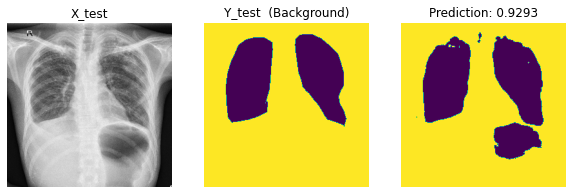

1/1 [==============================] - 0s 87ms/step - loss: 0.0707 - dice_coef: 0.9293


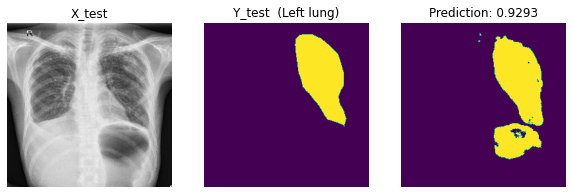

1/1 [==============================] - 0s 92ms/step - loss: 0.0707 - dice_coef: 0.9293


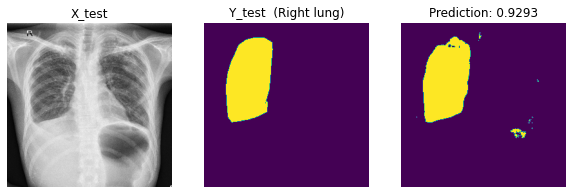

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀ TEST END ◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀


In [26]:
plotPredictions(X_test[39:40], y_test[39:40], model)

## 5-3. 특정 영역 제거 후 예측(현재는 X_test[39]의 데이터)

In [27]:
input_ = X_test[39:40] # numpy (1, 256, 256, 3)
print(input_.shape)

mask_ = y_test[39:40] # numpy (1, 256, 256, 3)
preds_test = model.predict(input_) # numpy 예측 결과 (1, 256, 256, 3)
preds_test_t = (preds_test > 0.5).astype(np.uint8)  # numpy 경계값 기준으로 

(1, 256, 256, 3)


In [28]:
background = preds_test_t[0][:,:,0]
left = preds_test_t[0][:,:,1]
right = preds_test_t[0][:,:,2]
print(background.shape)
print(left.shape)
print(right.shape)

(256, 256)
(256, 256)
(256, 256)


### 5-3-1. Background

In [29]:
np.random.seed(777)

cnt_b, labels_b = cv2.connectedComponents(background)
# print(cnt_b) # 6
# print(labels_b.shape) # (256, 256)

background_copy = np.zeros_like(background) # (256, 256)
for i in range(cnt_b):
    background_copy[labels_b==i] = [int(j) for j in np.random.randint(0, 255, 1)]
    
# print(np.unique(background)) # [0 1]
# print(np.unique(background, return_counts=True))
# (array([0, 1], dtype=uint8), array([17690, 47846], dtype=int64))

# print(np.unique(background_copy)) # [ 47  59  87 103 166 177]
# print(np.unique(background_copy, return_counts=True)) # numpy
# (array([ 47,  59,  87, 103, 166, 177], dtype=uint8),
# array([47817,    14,     3, 17690,     9,     3], dtype=int64))

# opencv 시각화
# cv2.imshow('orgin', background)
# cv2.imshow('lump', background_copy)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [30]:
background_total = np.unique(background_copy, return_counts=True)
b_idx = background_total[0]
b_lump = background_total[1]

# print(np.argmax(b_lump)) # 0
# print(b_idx[np.argmax(b_lump)]) # 47

background_copy[background_copy==b_idx[np.argmax(b_lump)]] = 1
background_copy[background_copy!=1] = 0 

In [31]:
print(background_copy.shape)
print(background_copy)
print(background_copy[background_copy==0].shape)
print(background_copy[background_copy==1].shape)
print(background_copy.shape)

(256, 256)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
(17719,)
(47817,)
(256, 256)


### 5-3-2. Left lung

In [32]:
np.random.seed(777)

cnt_l, labels_l = cv2.connectedComponents(left)
# print(cnt_l) # 8
# print(labels_l.shape) # (256, 256)

left_copy = np.zeros_like(left) # (256, 256)
for i in range(cnt_l):
    left_copy[labels_l==i] = [int(j) for j in np.random.randint(0, 255, 1)]

# print(np.unique(left)) # [0 1]
# print(np.unique(left, return_counts=True))
# (array([0, 1], dtype=uint8), array([55639,  9897], dtype=int64))

# print(np.unique(left_copy)) # [ 47  59  71  87 103 157 166 177]
# print(np.unique(left_copy, return_counts=True)) # numpy
# (array([ 47,  59,  71,  87, 103, 157, 166, 177], dtype=uint8),
# array([    7,  7082,     1,  2799, 55639,     1,     6,     1], dtype=int64))  

# opencv 시각화
# cv2.imshow('orgin', left)
# cv2.imshow('lump', left_copy)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [33]:
left_total = np.unique(left_copy, return_counts=True)
l_idx = left_total[0]
l_lump = left_total[1]

# print(np.argmax(l_lump)) # 4
# print(l_idx[np.argmax(l_lump)]) # 103

l_idx = np.delete(l_idx, np.argmax(left_total[1]))
l_lump = np.delete(l_lump, np.argmax(left_total[1]))

# print(np.argmax(l_lump)) # 1
# print(l_idx[np.argmax(l_lump)]) # 59

left_copy[left_copy==l_idx[np.argmax(l_lump)]] = 1
left_copy[left_copy!=1] = 0

In [34]:
print(left_copy.shape)
print(left_copy)
print(left_copy[left_copy==0].shape)
print(left_copy[left_copy==1].shape)
print(left_copy.shape)

(256, 256)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(58454,)
(7082,)
(256, 256)


### 5-3-3. Right lung

In [35]:
np.random.seed(777)

cnt_r, labels_r = cv2.connectedComponents(right)
# print(cnt_r) # 17
# print(labels_r.shape) # (256, 256)

right_copy = np.zeros_like(right) # (256, 256)
for i in range(cnt_r):
    right_copy[labels_r==i] = [int(j) for j in np.random.randint(0, 255, 1)]

# print(np.unique(right)) # [0 1]
# print(np.unique(right, return_counts=True))
# (array([0, 1], dtype=uint8), array([57796,  7740], dtype=int64))

# print(np.unique(right_copy)) # [ 24  39  46  47  59  71  87 103 116 127 146 157 166 167 177 217 250]
# print(np.unique(right_copy, return_counts=True)) # numpy
# (array([ 24,  39,  46,  47,  59,  71,  87, 103, 116, 127, 146, 157, 166,
#          167, 177, 217, 250], dtype=uint8),
#  array([  165,     2,     1,     1,    18,     4,     1, 57796,     5,
#            2,     1,     1,  7535,     1,     1,     1,     1], dtype=int64))

# opencv 시각화
# cv2.imshow('orgin', right)
# cv2.imshow('lump', right_copy)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [36]:
right_total = np.unique(right_copy, return_counts=True)
r_idx = right_total[0]
r_lump = right_total[1]

# print(np.argmax(r_lump)) # 7
# print(r_idx[np.argmax(r_lump)]) # 103

r_idx = np.delete(r_idx, np.argmax(right_total[1]))
r_lump = np.delete(r_lump, np.argmax(right_total[1]))

# print(np.argmax(r_lump)) # 11
# print(r_idx[np.argmax(r_lump)]) # 166

right_copy[right_copy==r_idx[np.argmax(r_lump)]] = 1
right_copy[right_copy!=1] = 0

In [37]:
print(right_copy.shape)
print(right_copy)
print(right_copy[right_copy==0].shape)
print(right_copy[right_copy==1].shape)
print(right_copy.shape)

(256, 256)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(58001,)
(7535,)
(256, 256)


- 배경: 배경의 가장 큰 픽셀 부분만을 남긴다.
- 좌폐: 좌폐의 가장 큰 픽셀 부분만을 남긴다.
- 우폐: 우폐의 가장 큰 픽셀 부분만을 남긴다.

In [38]:
print(background.shape)
print(left.shape)
print(right.shape)
print(background_copy.shape)
print(left_copy.shape)
print(right_copy.shape)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


In [39]:
bg = np.expand_dims(background_copy, axis=-1)
ll = np.expand_dims(left_copy, axis=-1)
rl = np.expand_dims(right_copy, axis=-1)
print(bg.shape)
print(ll.shape)
print(rl.shape)

(256, 256, 1)
(256, 256, 1)
(256, 256, 1)


In [40]:
total = np.concatenate((bg, ll, rl), axis=2)
total_ = np.expand_dims(total, axis=0)
print(total_.shape)
# print(total_)

(1, 256, 256, 3)


In [41]:
input_ = total_ # (1, 256, 256, 3)
# print(total_.shape) # (1, 256, 256, 3)

mask_ = y_test[39:40]
preds_test_t = total_

1/1 [==============================] - 0s 297ms/step - loss: 0.2252 - dice_coef: 0.7748


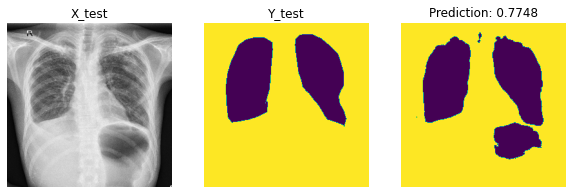

1/1 [==============================] - 0s 90ms/step - loss: 0.2252 - dice_coef: 0.7748


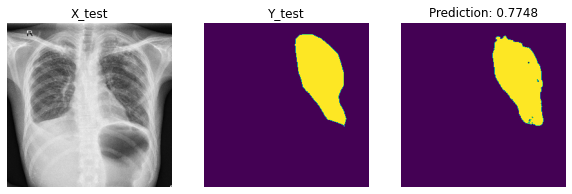

1/1 [==============================] - 0s 88ms/step - loss: 0.2252 - dice_coef: 0.7748


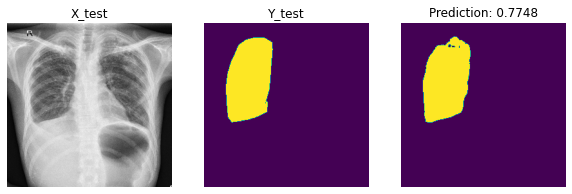

In [42]:
plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.title("X_test")
plt.axis('off')
# plt.imshow(input_[0])
plt.imshow(X_test[39:40][0])

plt.subplot(1,3,2)
plt.title("Y_test")
plt.axis('off')
plt.imshow(mask_[0][:,:,0])#, 'gray')

plt.subplot(1,3,3)
ret = model.evaluate(input_, mask_)
# ret = model.evaluate(total_, mask_)
plt.title("Prediction: %.4f" % (ret[1]))
plt.axis('off')
plt.imshow(preds_test_t[0][:,:,0])#, 'gray')

plt.show()


plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.title("X_test")
plt.axis('off')
# plt.imshow(input_[0])
plt.imshow(X_test[39:40][0])

plt.subplot(1,3,2)
plt.title("Y_test")
plt.axis('off')
plt.imshow(mask_[0][:,:,1])#, 'gray')

plt.subplot(1,3,3)
ret = model.evaluate(input_, mask_)
# ret = model.evaluate(total_, mask_)
plt.title("Prediction: %.4f" % (ret[1]))
plt.axis('off')
plt.imshow(preds_test_t[0][:,:,1])#, 'gray')

plt.show()


plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.title("X_test")
plt.axis('off')
# plt.imshow(input_[0])
plt.imshow(X_test[39:40][0])

plt.subplot(1,3,2)
plt.title("Y_test")
plt.axis('off')
plt.imshow(mask_[0][:,:,2])#, 'gray')

plt.subplot(1,3,3)
ret = model.evaluate(input_, mask_)
# ret = model.evaluate(total_, mask_)
plt.title("Prediction: %.4f" % (ret[1]))
plt.axis('off')
plt.imshow(preds_test_t[0][:,:,2])#, 'gray')

plt.show()

In [43]:
# print(mask_.shape)
# print(mask_[0][:,:,0])
# print(mask_[0][:,:,1])
# print(mask_[0][:,:,2])

## 5-4. 모폴로지 연산 후 예측

In [44]:
back_morphology = total_[0][:,:,0]
left_morphology = total_[0][:,:,1]
right_morphology = total_[0][:,:,2]

# 침식 corrosion
corrosion = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
# ? = cv2.erode(, corrosion)

# 팽창 expansion
left_expansion = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
right_expansion = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 3))

left_mor_exp = cv2.dilate(left_morphology, left_expansion)
right_mor_exp = cv2.dilate(right_morphology, right_expansion)

1/1 [==============================] - 0s 88ms/step - loss: 0.2252 - dice_coef: 0.7748


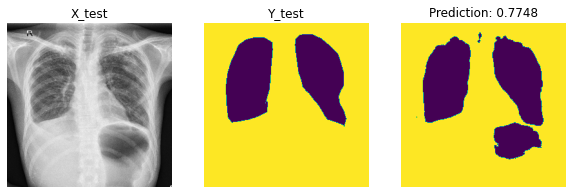

1/1 [==============================] - 0s 90ms/step - loss: 0.2252 - dice_coef: 0.7748


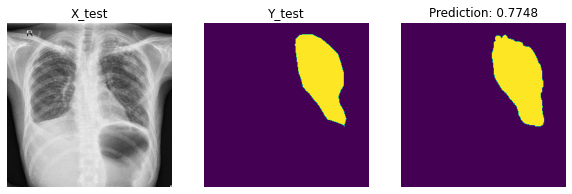

1/1 [==============================] - 0s 91ms/step - loss: 0.2252 - dice_coef: 0.7748


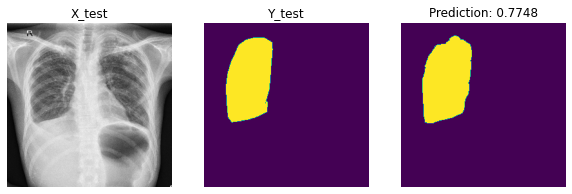

In [45]:
# 테스팅

plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.title("X_test")
plt.axis('off')
# plt.imshow(input_[0])
plt.imshow(X_test[39:40][0])

plt.subplot(1,3,2)
plt.title("Y_test")
plt.axis('off')
plt.imshow(mask_[0][:,:,0])#, 'gray')

plt.subplot(1,3,3)
ret = model.evaluate(input_, mask_)
# ret = model.evaluate(total_, mask_)
plt.title("Prediction: %.4f" % (ret[1]))
plt.axis('off')
plt.imshow(preds_test_t[0][:,:,0])#, 'gray')

plt.show()


plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.title("X_test")
plt.axis('off')
# plt.imshow(input_[0])
plt.imshow(X_test[39:40][0])

plt.subplot(1,3,2)
plt.title("Y_test")
plt.axis('off')
plt.imshow(mask_[0][:,:,1])#, 'gray')

plt.subplot(1,3,3)
ret = model.evaluate(input_, mask_)
# ret = model.evaluate(total_, mask_)
plt.title("Prediction: %.4f" % (ret[1]))
plt.axis('off')
# plt.imshow(preds_test_t[0][:,:,1])#, 'gray')
plt.imshow(left_mor_exp)#, 'gray')

plt.show()


plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.title("X_test")
plt.axis('off')
# plt.imshow(input_[0])
plt.imshow(X_test[39:40][0])

plt.subplot(1,3,2)
plt.title("Y_test")
plt.axis('off')
plt.imshow(mask_[0][:,:,2])#, 'gray')

plt.subplot(1,3,3)
ret = model.evaluate(input_, mask_)
# ret = model.evaluate(total_, mask_)
plt.title("Prediction: %.4f" % (ret[1]))
plt.axis('off')
# plt.imshow(preds_test_t[0][:,:,2])#, 'gray')
plt.imshow(right_mor_exp)#, 'gray')

plt.show()

## 5-?. 이번 과정은 X_test[34]의 데이터로 진행한다.

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶ TEST START ▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
-------------------------------- ix: 0   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 97ms/step - loss: 0.0938 - dice_coef: 0.9062


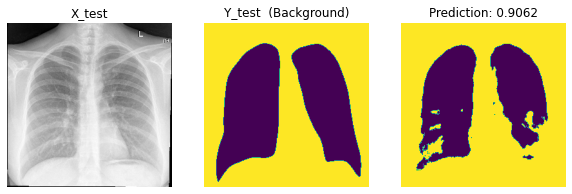

1/1 [==============================] - 0s 87ms/step - loss: 0.0938 - dice_coef: 0.9062


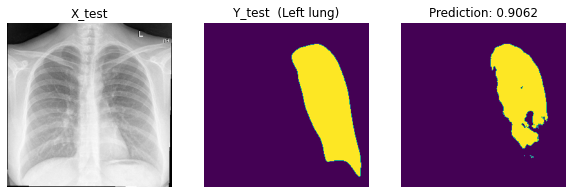

1/1 [==============================] - 0s 87ms/step - loss: 0.0938 - dice_coef: 0.9062


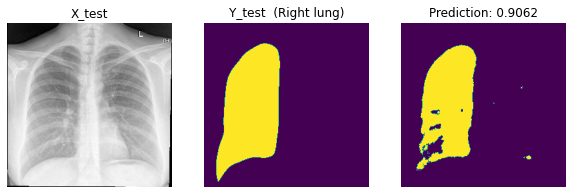

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀ TEST END ◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀


In [46]:
plotPredictions(X_test[34:35], y_test[34:35], model)

In [47]:
input_ = X_test[34:35] # numpy (1, 256, 256, 3)
print(input_.shape)

mask_ = y_test[34:35] # numpy (1, 256, 256, 3)
preds_test = model.predict(input_) # numpy 예측 결과 (1, 256, 256, 3)
preds_test_t = (preds_test > 0.5).astype(np.uint8)  # numpy 경계값 기준으로 

(1, 256, 256, 3)


In [48]:
# print(mask_.shape)
# print(mask_[0][:,:,0])
# print(mask_[0][:,:,1])
# print(mask_[0][:,:,2])

## 5-4. 모폴로지 연산 후 예측

In [49]:
back_morphology = preds_test_t[0][:,:,0]
left_morphology = preds_test_t[0][:,:,1]
right_morphology = preds_test_t[0][:,:,2]

# 침식 corrosion
left_corrosion = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
right_corrosion = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 5))

left_mor_cor = cv2.erode(left_morphology, left_corrosion)
right_mor_cor = cv2.erode(right_morphology, right_corrosion)

# 팽창 expansion
left_expansion = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
right_expansion = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
# right_expansion = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (23, 23))

# left_mor_exp = cv2.dilate(left_morphology, left_expansion)
# right_mor_exp = cv2.dilate(right_morphology, right_expansion)
left_mor_exp = cv2.dilate(left_mor_cor, left_expansion)
right_mor_exp = cv2.dilate(right_mor_cor, right_expansion)

In [50]:
back_morphology = np.expand_dims(back_morphology, axis=-1)
left_mor_cor = np.expand_dims(left_mor_cor, axis=-1)
right_mor_cor = np.expand_dims(right_mor_cor, axis=-1)
print(back_morphology.shape)
print(left_mor_cor.shape)
print(right_mor_cor.shape)

left_mor_exp = np.expand_dims(left_mor_exp, axis=-1)
right_mor_exp = np.expand_dims(right_mor_exp, axis=-1)
print(left_mor_exp.shape)
print(right_mor_exp.shape)

# total = np.concatenate((back_morphology, left_mor_cor, right_mor_cor), axis=2)
total = np.concatenate((back_morphology, left_mor_exp, right_mor_exp), axis=2)
total_ = np.expand_dims(total, axis=0)
print(total_.shape)

(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(1, 256, 256, 3)


1/1 [==============================] - 0s 89ms/step - loss: 0.3992 - dice_coef: 0.6008


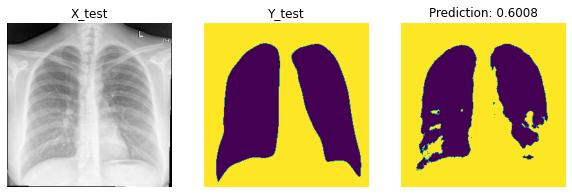

1/1 [==============================] - 0s 94ms/step - loss: 0.3992 - dice_coef: 0.6008


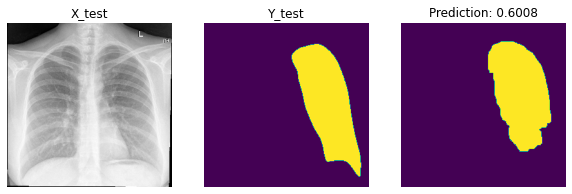

1/1 [==============================] - 0s 91ms/step - loss: 0.3992 - dice_coef: 0.6008


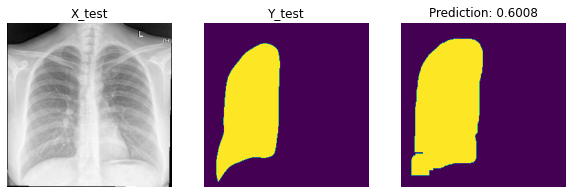

In [51]:
plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.title("X_test")
plt.axis('off')
# plt.imshow(input_[0])
plt.imshow(X_test[34:35][0])

plt.subplot(1,3,2)
plt.title("Y_test")
plt.axis('off')
plt.imshow(mask_[0][:,:,0])#, 'gray')

plt.subplot(1,3,3)
# ret = model.evaluate(input_, mask_)
ret = model.evaluate(total_, mask_)
plt.title("Prediction: %.4f" % (ret[1]))
plt.axis('off')
plt.imshow(preds_test_t[0][:,:,0])#, 'gray')

plt.show()


plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.title("X_test")
plt.axis('off')
# plt.imshow(input_[0])
plt.imshow(X_test[34:35][0])

plt.subplot(1,3,2)
plt.title("Y_test")
plt.axis('off')
plt.imshow(mask_[0][:,:,1])#, 'gray')

plt.subplot(1,3,3)
# ret = model.evaluate(input_, mask_)
ret = model.evaluate(total_, mask_)
plt.title("Prediction: %.4f" % (ret[1]))
plt.axis('off')
# plt.imshow(preds_test_t[0][:,:,1])#, 'gray')
# plt.imshow(left_mor_cor)#, 'gray')
plt.imshow(left_mor_exp)#, 'gray')


plt.show()


plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.title("X_test")
plt.axis('off')
# plt.imshow(input_[0])
plt.imshow(X_test[34:35][0])

plt.subplot(1,3,2)
plt.title("Y_test")
plt.axis('off')
plt.imshow(mask_[0][:,:,2])#, 'gray')

plt.subplot(1,3,3)
# ret = model.evaluate(input_, mask_)
ret = model.evaluate(total_, mask_)
plt.title("Prediction: %.4f" % (ret[1]))
plt.axis('off')
# plt.imshow(preds_test_t[0][:,:,2])#, 'gray')
# plt.imshow(right_mor_cor)#, 'gray')
plt.imshow(right_mor_exp)#, 'gray')

plt.show()

## 5-?. Prediction Visualization

In [140]:
# def plotPredictions(X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_, simpleFCN):
def plotPredictions(X_test_, y_test_, useModel):
    model = useModel

    print("▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶ TEST START ▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶")
    for ix in range(len(X_test_)):
        print(f"-------------------------------- ix: {ix}   --------------------------------")
        print(f"■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ {ix} START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
        
        input_ = X_test_[ix:ix+1]
        mask_ = y_test_[ix:ix+1]
        preds_test = model.predict(input_)
        preds_test_t = (preds_test > 0.5).astype(np.uint8)

        for i in range(3):
            if i == 0:
                comment = "Background"
            elif i == 1:
                comment = "Left lung"
            elif i == 2:
                comment = "Right lung"
                
            plt.figure(figsize=(10,10))

            plt.subplot(1,3,1)
            plt.title("X_test")
            plt.axis('off')
            plt.imshow(input_[0])

            plt.subplot(1,3,2)
            plt.title(f"Y_test  ({comment})")
            plt.axis('off')
            plt.imshow(mask_[0][:,:,i])#, 'gray')

            plt.subplot(1,3,3)
            ret = model.evaluate(input_, mask_)
            plt.title("Prediction: %.4f" % (ret[1]))
            plt.axis('off')
            plt.imshow(preds_test_t[0][:,:,i])#, 'gray')

            plt.show()

        print(f"■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ {ix} END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
        print(f"-------------------------------------------------------------------------")
    print("◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀ TEST END ◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀")

### 5-?-?. 전체 데이터

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ TRAIN START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  0
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 31ms/step - loss: 0.0117 - dice_coef: 0.9883


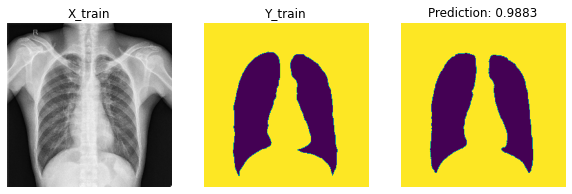

1/1 [==============================] - 0s 31ms/step - loss: 0.0117 - dice_coef: 0.9883


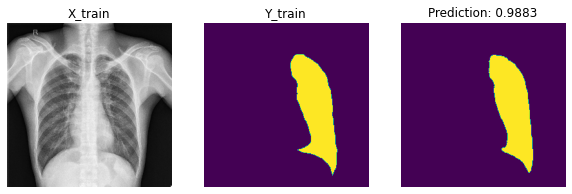

1/1 [==============================] - 0s 16ms/step - loss: 0.0117 - dice_coef: 0.9883


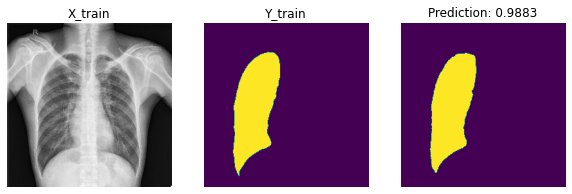

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ TRAIN END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ VALID START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  0
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 26ms/step - loss: 0.0444 - dice_coef: 0.9556


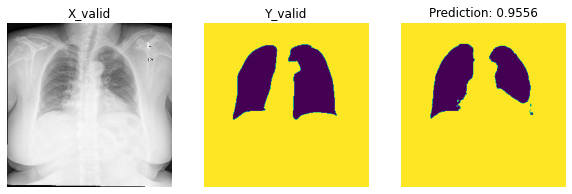

1/1 [==============================] - 0s 22ms/step - loss: 0.0444 - dice_coef: 0.9556


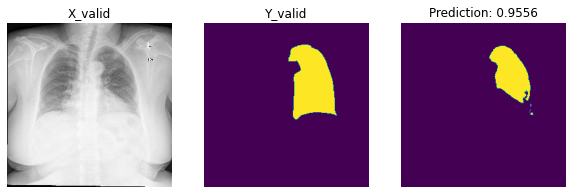

1/1 [==============================] - 0s 31ms/step - loss: 0.0444 - dice_coef: 0.9556


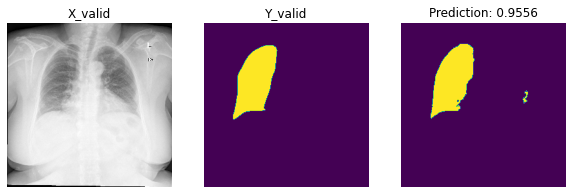

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ VALID END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ TEST START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  0
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 28ms/step - loss: 0.0167 - dice_coef: 0.9833


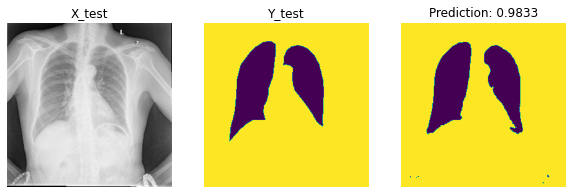

1/1 [==============================] - 0s 26ms/step - loss: 0.0167 - dice_coef: 0.9833


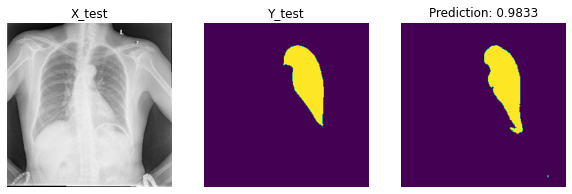

1/1 [==============================] - 0s 16ms/step - loss: 0.0167 - dice_coef: 0.9833


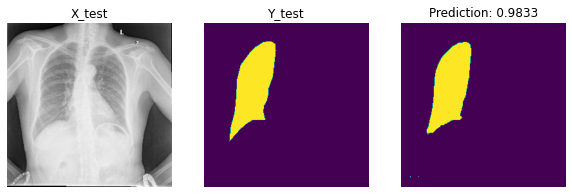

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ TEST END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■


In [245]:
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

### 5-?-?. 낮은 dice_coef(0.95↓) case plot

X_train |&nbsp;&nbsp; length:  15, list index:&nbsp;&nbsp;[6, 11, 14, 95, 121, 140, 146, 148, 152, 213, 219, 260, 320, 325, 343]
<br>
X_valid |&nbsp;&nbsp; length:  11, list index:&nbsp;&nbsp;[5, 7, 20, 24, 39, 45, 52, 67, 79, 81, 83]
<br>
X_test&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp; length: 7, &nbsp;&nbsp;list index:&nbsp;&nbsp;[19, 25, 34, 39, 57, 67, 109]

- test 데이터 기준 0.95 미만
    - 폐 영역 파임(외부): 0(좌우), 1(좌), 4(좌 조금), 5(좌)
    - 폐 영역 파임(내부): 2(좌우)
    - 노이즈: 3(좌)
    - 특이 케이스: 6

▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶ TEST START ▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
-------------------------------- ix: 0   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 90ms/step - loss: 0.0676 - dice_coef: 0.9324


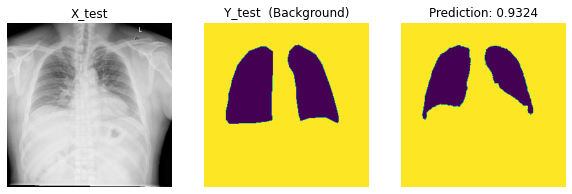

1/1 [==============================] - 0s 89ms/step - loss: 0.0676 - dice_coef: 0.9324


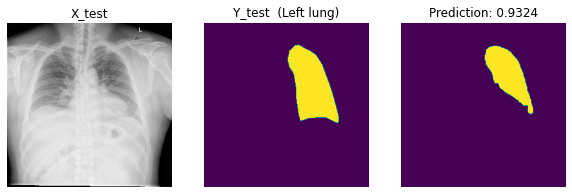

1/1 [==============================] - 0s 93ms/step - loss: 0.0676 - dice_coef: 0.9324


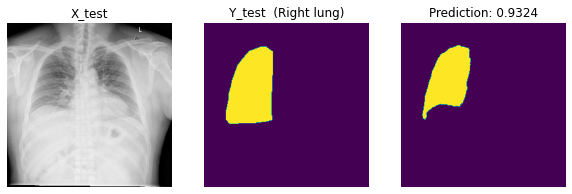

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 1   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 1 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 100ms/step - loss: 0.0632 - dice_coef: 0.9368


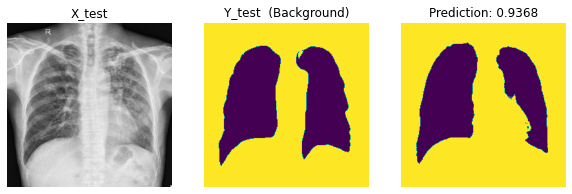

1/1 [==============================] - 0s 89ms/step - loss: 0.0632 - dice_coef: 0.9368


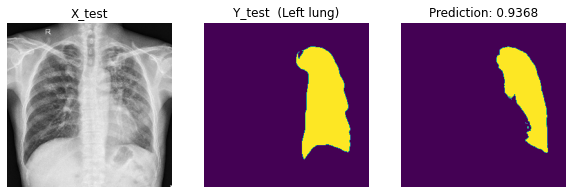

1/1 [==============================] - 0s 97ms/step - loss: 0.0632 - dice_coef: 0.9368


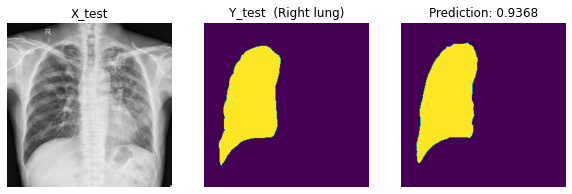

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 1 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 2   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 2 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 90ms/step - loss: 0.0938 - dice_coef: 0.9062


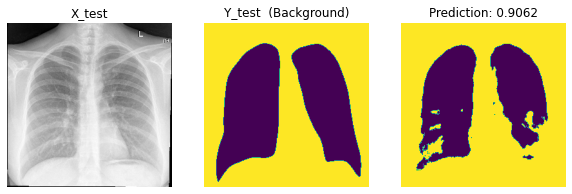

1/1 [==============================] - 0s 93ms/step - loss: 0.0938 - dice_coef: 0.9062


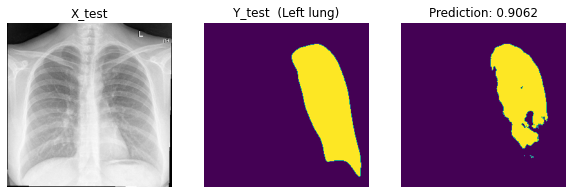

1/1 [==============================] - 0s 89ms/step - loss: 0.0938 - dice_coef: 0.9062


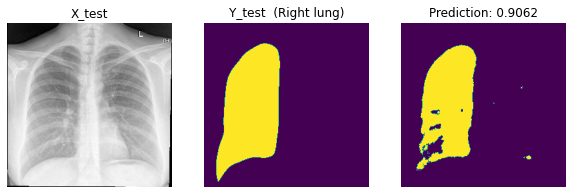

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 2 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 3   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 3 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 96ms/step - loss: 0.0707 - dice_coef: 0.9293


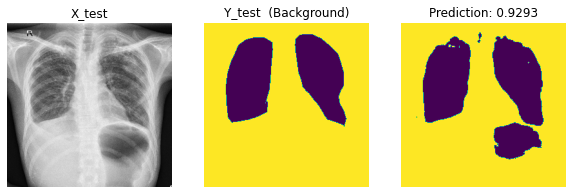

1/1 [==============================] - 0s 95ms/step - loss: 0.0707 - dice_coef: 0.9293


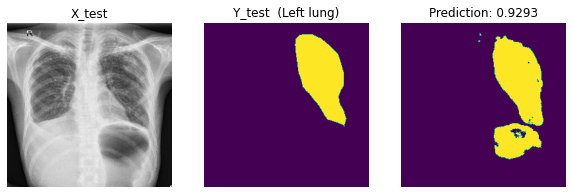

1/1 [==============================] - 0s 90ms/step - loss: 0.0707 - dice_coef: 0.9293


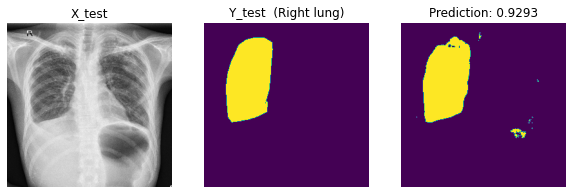

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 3 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 4   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 4 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 92ms/step - loss: 0.0532 - dice_coef: 0.9468


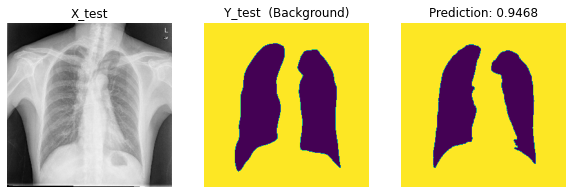

1/1 [==============================] - 0s 93ms/step - loss: 0.0532 - dice_coef: 0.9468


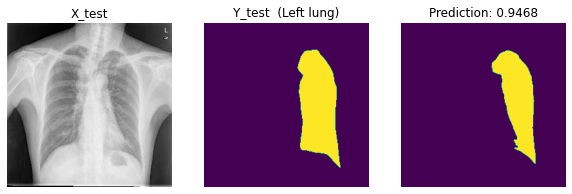

1/1 [==============================] - 0s 92ms/step - loss: 0.0532 - dice_coef: 0.9468


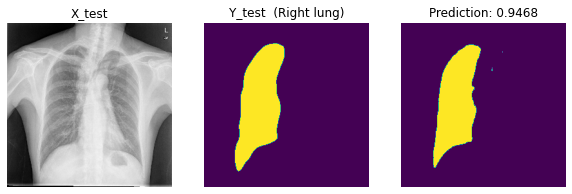

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 4 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 5   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 5 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 93ms/step - loss: 0.0662 - dice_coef: 0.9338


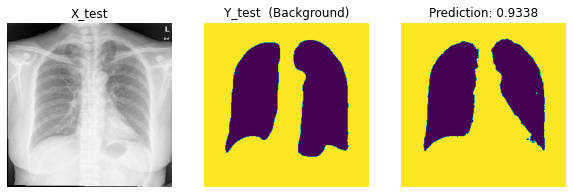

1/1 [==============================] - 0s 93ms/step - loss: 0.0662 - dice_coef: 0.9338


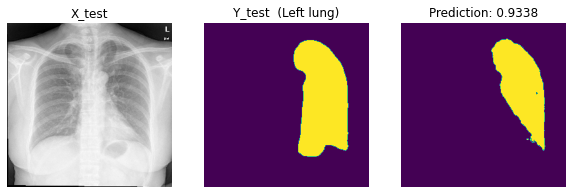

1/1 [==============================] - 0s 91ms/step - loss: 0.0662 - dice_coef: 0.9338


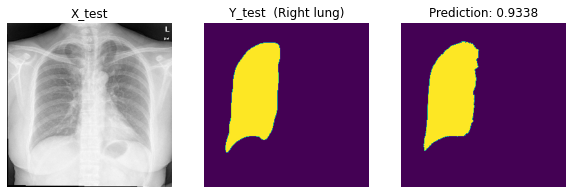

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 5 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
-------------------------------- ix: 6   --------------------------------
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 6 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 90ms/step - loss: 0.0630 - dice_coef: 0.9370


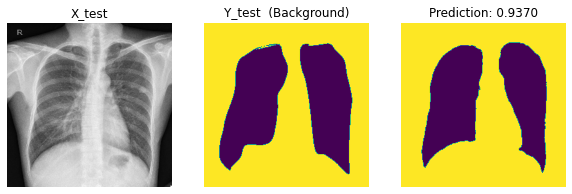

1/1 [==============================] - 0s 96ms/step - loss: 0.0630 - dice_coef: 0.9370


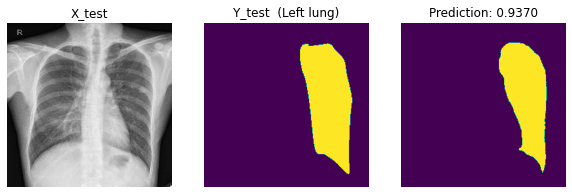

1/1 [==============================] - 0s 107ms/step - loss: 0.0630 - dice_coef: 0.9370


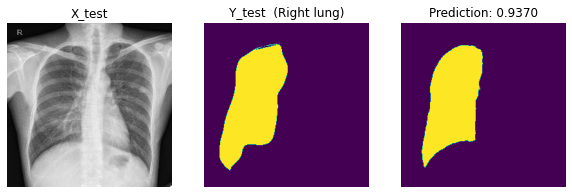

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 6 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
-------------------------------------------------------------------------
◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀ TEST END ◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀


In [141]:
plotPredictions(X_test_095_down, y_test_095_down, model)